In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

import string
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ryankirkland/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df = pd.read_csv('../data/total_reviews.csv')
cleaned = pd.read_csv('../data/cleaned_reviews.csv')

In [3]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [77]:
dates = cleaned.groupby('date').mean()

In [95]:
dr = pd.date_range(dates.index[0], dates.index[-1])
d = pd.DataFrame(dr).rename(columns={0:'dates'})

In [98]:
dates.index = pd.to_datetime(dates.index)

In [155]:
new = d.merge(dates, how='outer', left_on='dates', right_index=True)

In [152]:
dates['moving'] = dates.rating.rolling(10, min_periods=1).mean()

In [157]:
new = new.fillna(method='ffill')

In [158]:
new

,dates,Unnamed: 0,rating,month,year,moving
0,2018-03-12,505.500000,3.000000,3.0,2018.0,3.000000
1,2018-03-13,505.500000,3.000000,3.0,2018.0,3.000000
2,2018-03-14,505.500000,3.000000,3.0,2018.0,3.000000
3,2018-03-15,505.500000,3.000000,3.0,2018.0,3.000000
4,2018-03-16,505.500000,3.000000,3.0,2018.0,3.000000
...,...,...,...,...,...,...
890,2020-08-18,1702.666667,4.333333,8.0,2020.0,4.329762
891,2020-08-19,1493.250000,4.000000,8.0,2020.0,4.299762
892,2020-08-20,1583.200000,4.600000,8.0,2020.0,4.316905
893,2020-08-21,2140.571429,4.428571,8.0,2020.0,4.331190


In [108]:
new = new.fillna(0)

In [146]:
new.groupby('dates')['rating'].transform(lambda x: x.rolling(1, 1).mean())

0      3.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
890    4.333333
891    4.000000
892    4.600000
893    4.428571
894    5.000000
Name: rating, Length: 895, dtype: float64

In [121]:
new.to_csv('date_range.csv')

In [123]:
t = pd.read_csv('../data/date_range.csv')

In [124]:
t.head()

,Unnamed: 0,dates,Unnamed: 0.1,rating,month,year
0,0,2018-03-12,505.5,3.0,3.0,2018.0
1,1,2018-03-13,0.0,0.0,0.0,0.0
2,2,2018-03-14,0.0,0.0,0.0,0.0
3,3,2018-03-15,0.0,0.0,0.0,0.0
4,4,2018-03-16,0.0,0.0,0.0,0.0


In [7]:
def create_daterange(df):
    """
    Create date range from earliest and latest dates in
    DataFrame to create a new DataFrame for time series
    visualization.
    
    INPUT: Pandas DataFrame with 'date' column name
    
    OUTPUT: New DataFrame with 'dates' as index and mean
    grouped data.
    """
    date_group = df.groupby('date').mean()
    date_group['moving'] = date_group.rating.rolling(30, min_periods=1).mean()
    date_group.index = pd.to_datetime(date_group.index)
    dates = pd.date_range(date_group.index[0], date_group.index[-1])
    dates_df = pd.DataFrame(dates).rename(columns={0: 'dates'})
    date_df = dates_df.merge(date_group, how='outer', left_on='dates', right_index=True)
    date_df = date_df.fillna(method='ffill')
    return date_df

In [8]:
test = create_daterange(cleaned)

In [10]:
test.to_csv('date_range.csv')

In [34]:
def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ 

    elif pos_tag.startswith('V'):
        return wordnet.VERB 

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN # default, return wordnet tag "NOUN"

#Create a function to lemmatize tokens in the reviews
def lemmatized_tokens(text):
        text = text.lower()
        pattern = r'\b[a-zA-Z]{3,}\b'                 
        tokens = nltk.regexp_tokenize(text, pattern) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # a list of tuples (word, pos_tag)
          
        stop_words = stopwords.words('english')
        new_stopwords = []  #customize extra stop_words
        stop_words.extend(new_stopwords)
        stop_words = set(stop_words)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        # get lemmatized tokens                             #call function "get_wordnet_pos"
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                  # tagged_tokens is a list of tuples (word, tag)
                  for (word, tag) in tagged_tokens \
                  # remove stop words
                  if word not in stop_words and \
                  # remove punctuations
                  word not in string.punctuation]

        return lemmatized_words

In [6]:
cleaned = cleaned.drop('Unnamed: 0', axis=1)

In [7]:
cleaned.head()

,asin,product,date,verified,title,desc,reviewer_name,rating,month,year,month_year,title_desc
0,B08267BBJT,AAA,2020-08-11,Verified Purchase,"Didn't work, then worked, now don't work again",All I got in terms of use out of these batter...,Jasmine Carroll,1.0,8,2020,2020-08,"Didn't work, then worked, now don't work again..."
1,B08267BBJT,AAA,2020-07-30,Verified Purchase,These absolutely suck,I bought these for a wall mounted magnifying ...,Ashlee M.,1.0,7,2020,2020-07,These absolutely suck I bought these for a wal...
2,B08268F6XN,AA,2020-07-19,Verified Purchase,longer lasting battery for remote controller!!,i like the constant voltage and hopefully it ...,ARCHANGEL TROY,5.0,7,2020,2020-07,longer lasting battery for remote controller!!...
3,B08267BBJT,AAA,2020-07-18,Verified Purchase,Minimal plastic in packaging.,"Just received these today, but I’m reviewing ...",ira,5.0,7,2020,2020-07,Minimal plastic in packaging. Just received th...
4,B08267BBJT,AAA,2020-07-17,Verified Purchase,Not long enough battery life for a night hike,Shuts off suddenly in headlamp,T,3.0,7,2020,2020-07,Not long enough battery life for a night hike ...


In [49]:
neg = cleaned[cleaned['rating'] < 3.0]
test_txt = neg.loc[0, 'title_desc']

In [50]:
lemmed_test = lemmatized_tokens(test_txt)

In [51]:
lemmed_test

['work',
 'work',
 'work',
 'get',
 'term',
 'use',
 'battery',
 'three',
 'day',
 'use',
 'two',
 'additional',
 'success',
 'buy',
 'bleed',
 'aaa',
 'battery',
 'hop',
 'compact',
 'design',
 'would',
 'better',
 'something',
 'bulky',
 'right',
 'box',
 'charge',
 'light',
 'green',
 'indicate',
 'fully',
 'charge',
 'try',
 'use',
 'couple',
 'device',
 'luck',
 'go',
 'return',
 'friend',
 'suggest',
 'switch',
 'charge',
 'extension',
 'cord',
 'directly',
 'wall',
 'socket',
 'think',
 'trick',
 'even',
 'though',
 'thought',
 'silly',
 'try',
 'battery',
 'device',
 'let',
 'charge',
 'overnight',
 'plug',
 'directly',
 'wall',
 'socket',
 'work',
 'work',
 'well',
 'three',
 'day',
 'later',
 'device',
 'stop',
 'work',
 'middle',
 'high',
 'power',
 'usage',
 'hair',
 'trimmer',
 'swap',
 'battery',
 'two',
 'charge',
 'entire',
 'time',
 'work',
 'go',
 'buy',
 'regular',
 'aaa',
 'battery',
 'device',
 'go',
 'back',
 'work',
 'fine',
 'try',
 'battery',
 'device',
 'work'

In [52]:
#Create a function to build the optimal LDA model
def optimal_lda_model(df, review_colname):
    '''
    INPUTS:
        df_review - dataframe that contains the reviews
        review_colname: name of column that contains reviews
        
    OUTPUTS:
        lda_tfidf - Latent Dirichlet Allocation (LDA) model
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
        A graph comparing LDA Model Performance Scores with different params
    '''
    docs_raw = df[review_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                    stop_words = 'english',
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                                    max_df = 0.8,                        # discard words that appear in > 90% of the reviews
                                    min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], review_colname, dtm_tfidf.shape[1]))

    
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [5, 10], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)


    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))


    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [5, 10]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
#     plt.figure(figsize=(12, 8))
#     plt.plot(n_topics, log_likelyhoods_5, label='0.5')
#     plt.plot(n_topics, log_likelyhoods_7, label='0.7')
#     plt.plot(n_topics, log_likelyhoods_9, label='0.9')
#     plt.title("Choosing Optimal LDA Model")
#     plt.xlabel("Num Topics")
#     plt.ylabel("Log Likelyhood Scores")
#     plt.legend(title='Learning decay', loc='best')
#     plt.show()
    
    return gscore, best_lda_model, dtm_tfidf, tfidf_vectorizer

In [54]:
gscore, best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(neg, 'title_desc')

/Users/ryankirkland/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1798: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


The shape of the tfidf is (930, 343), meaning that there are 930 title_desc and 343 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Model Log Likelihood Score:  -4854.450316454082
Model Perplexity:  742.4970914342415


In [55]:
g = pd.DataFrame(gscore)

In [56]:
g

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.042339,0.014180,0.028726,0.001672,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-5138.126726,-4834.764842,-4847.498936,-4733.129867,-4824.935584,-4875.691191,137.289506,2
1,0.840787,0.006143,0.026842,0.001452,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-6241.768331,-5943.671005,-5870.112720,-5938.587484,-6038.826662,-6006.593240,129.272766,6
2,1.015984,0.013982,0.027693,0.001425,0.7,5,"{'learning_decay': 0.7, 'n_components': 5}",-5063.900441,-4822.203051,-4700.877019,-4626.961543,-4828.269541,-4808.442319,148.557662,1
3,0.828405,0.016873,0.023933,0.001142,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-5910.676093,-6088.513257,-5764.201514,-5678.676197,-5645.346232,-5817.482658,163.633533,4
4,1.052863,0.016046,0.029167,0.000918,0.9,5,"{'learning_decay': 0.9, 'n_components': 5}",-5052.019338,-4863.840826,-4787.179281,-4798.145381,-4887.154160,-4877.667797,95.070103,3
5,0.843358,0.006344,0.025214,0.001200,0.9,10,"{'learning_decay': 0.9, 'n_components': 10}",-6398.388161,-5948.035638,-5896.626127,-5961.567386,-5752.031260,-5991.329714,216.651459,5


In [57]:
#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display

    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names(), n_top_words = 20)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,batteries,30.6,charge,10.0,fit,10.4,batteries,10.6,charge,44.8
1,battery,22.7,long,9.9,batteries,10.4,china,10.6,batteries,39.4
2,charge,17.7,life,7.5,eneloops,8.4,charge,8.2,hold,31.0
3,bad,14.3,did,6.9,device,8.0,charger,8.2,don,25.7
4,charger,14.0,batteries,6.8,size,6.9,japan,6.8,money,20.0
5,charging,13.4,work,6.3,description,6.3,didn,6.6,charged,19.8
6,light,13.2,dead,5.4,japan,6.0,got,5.9,use,19.1
7,use,12.3,battery,5.4,china,5.8,work,5.6,battery,18.8
8,flashlight,11.9,recharge,5.3,larger,5.6,did,5.6,work,15.6
9,working,11.5,hold,5.3,amazon,5.6,package,5.4,buy,15.4


In [58]:
import pyLDAvis.sklearn
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.081674  0.001174       1        1  36.459106
0     -0.041220 -0.052512       2        1  30.528952
2      0.160087  0.055645       3        1  11.594971
3      0.036753 -0.102035       4        1  11.335681
1     -0.073946  0.097727       5        1  10.081290, topic_info=         Term       Freq      Total Category  logprob  loglift
51      china  16.000000  16.000000  Default  30.0000  30.0000
167      long  30.000000  30.000000  Default  29.0000  29.0000
160      life  16.000000  16.000000  Default  28.0000  28.0000
108       fit  11.000000  11.000000  Default  27.0000  27.0000
42     charge  72.000000  72.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
118      good   3.282092  25.158496   Topic5  -4.4938   0.2578
213     power   2.670232  14.576586   Topic5  -4.7001   0.5972
233  received   2.173467   9.316562   Topic5  -4.9060   0.8390
90        don   2.576474  36.209342   Topic5  -4.7359  -0.3484
168    longer   2.147630  16.113230   Topic5  -4.9179   0.2792

[274 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         3  0.548159         aas
1         4  0.274079         aas
2         2  0.413843        able
2         5  0.413843        able
4         1  0.169530  advertised
...     ...       ...         ...
341       5  0.087850        year
342       1  0.409995       years
342       2  0.102499       years
342       3  0.102499       years
342       5  0.307496       years

[517 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])

In [4]:
import gensim
from gensim.utils import simple_preprocess

In [5]:
import re

cleaned['processed_reviews'] = cleaned['title_desc'].apply(lambda x: re.sub('[,\.!?]', '', str(x)))

In [6]:
cleaned['processed_reviews'] = cleaned['processed_reviews'].apply(lambda x: x.lower())

In [7]:
def reviews_to_words(reviews):
    review_list = reviews.values.tolist()
    for review in reviews:
        yield(simple_preprocess(review, deacc=True)) #deacc=True removes punc

In [20]:
tokens = list(reviews_to_words(cleaned['processed_reviews']))

In [21]:
bigrams = gensim.models.Phrases(tokens, min_count=2)
bigram_mod = gensim.models.phrases.Phraser(bigrams)

In [8]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryankirkland/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stop_words = stopwords.words('english')
stop_words.extend(['good', 'battery', 'batteries', 'use', 'get', 'great', 'buy'])

import spacy

# Define functions for stopwords, lemmatization, bigrams, and trigrams

def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bi_mod):
    return [bi_mod[doc] for doc in texts]

def make_trigrams(texts, tri_mod):
    return [tri_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# Remove Stop Words
data_words_nostops = remove_stopwords(tokens)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

/Users/ryankirkland/anaconda3/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [10]:
import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)
# # Create Corpus
# texts = data_lemmatized
# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]
# # View
# print(corpus[:1])

In [26]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [11]:
from pprint import pprint
# # Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [12]:
from gensim.models import CoherenceModel
# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [29]:
# # supporting function
# def compute_coherence_values(corpus, dictionary, k, a, b):
    
#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=10, 
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b,
#                                            per_word_topics=True)
    
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
#     return coherence_model_lda.get_coherence()

In [30]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
#                # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
#                # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
#                corpus]
# corpus_title = ['100% Corpus']
# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

In [31]:
# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=540)
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
#     pbar.close()

NameError: name 'mr_alpha_group' is not defined

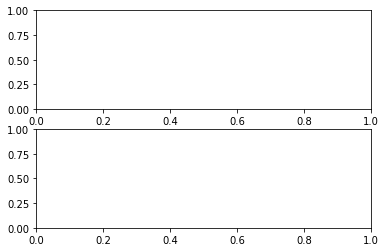

In [32]:
# fig, axs = plt.subplots(2)
# axs[0].plot(mr_alpha_group['Alpha'], mr_alpha_group['Coherence'])

In [ ]:
# mr = pd.DataFrame(model_results)

In [ ]:
# mr['Alpha'] = mr['Alpha'].map({'symmetric': 0})

In [ ]:
# mr['Alpha'].unique()

In [ ]:
# mr_alpha = mr[(mr['Alpha'] != 'symmetric') & (mr['Alpha'] != 'asymmetric')]

In [ ]:
# mr_alpha_group = mr_alpha.groupby('Alpha').mean().reset_index()

In [ ]:
# mr.sort_values('Coherence', ascending=False)

In [33]:
0.552422/0.44626446

1.2378803366954205

In [34]:
final_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.91)

In [13]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# # Visualize the topics
# pyLDAvis.enable_notebook()
# LDAvis_prepared = pyLDAvis.gensim.prepare(final_lda_model, corpus, id2word)
# LDAvis_prepared

In [14]:
neg = cleaned[cleaned['rating'] < 3.0]

In [15]:
neg_tokens = list(reviews_to_words(neg['processed_reviews']))
neg_bigrams = gensim.models.Phrases(neg_tokens, min_count=2)
neg_bigram_mod = gensim.models.phrases.Phraser(neg_bigrams)

In [20]:
# Remove Stop Words
neg_data_words_nostops = remove_stopwords(neg_tokens)
# Form Bigrams
neg_data_words_bigrams = make_bigrams(neg_data_words_nostops, neg_bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
neg_nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
neg_data_lemmatized = lemmatization(neg_data_words_bigrams, neg_nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [22]:
# Create Dictionary
neg_id2word = corpora.Dictionary(neg_data_lemmatized)
# Create Corpus
neg_texts = neg_data_lemmatized
# Term Document Frequency
neg_corpus = [neg_id2word.doc2bow(text) for text in neg_texts]
# View
print(len(neg_corpus))

930


In [71]:
# Build LDA model
neg_lda_model = gensim.models.LdaMulticore(corpus=neg_corpus,
                                       id2word=neg_id2word,
                                       num_topics=5,
                                       alpha=0.01,
                                       eta=0.91,
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [72]:
# Print the Keyword in the 10 topics
pprint(neg_lda_model.print_topics())
neg_doc_lda = neg_lda_model[neg_corpus]

[(0,
  '0.008*"make" + 0.006*"work" + 0.005*"recharge" + 0.005*"light" + '
  '0.005*"voltage" + 0.004*"dead" + 0.004*"time" + 0.004*"use" + 0.004*"less" '
  '+ 0.003*"show"'),
 (1,
  '0.051*"charge" + 0.018*"work" + 0.014*"use" + 0.012*"charger" + '
  '0.011*"last" + 0.008*"device" + 0.008*"put" + 0.008*"buy" + 0.007*"month" + '
  '0.007*"recharge"'),
 (2,
  '0.025*"charge" + 0.017*"last" + 0.012*"hour" + 0.008*"time" + 0.008*"use" + '
  '0.008*"buy" + 0.008*"rechargeable" + 0.007*"recharge" + 0.006*"try" + '
  '0.006*"long"'),
 (3,
  '0.015*"make" + 0.013*"charge" + 0.008*"work" + 0.008*"charger" + '
  '0.007*"use" + 0.007*"last" + 0.006*"product" + 0.006*"buy" + 0.005*"get" + '
  '0.005*"come"'),
 (4,
  '0.009*"long" + 0.008*"charge" + 0.008*"year" + 0.006*"purchase" + '
  '0.006*"buy" + 0.005*"flashlight" + 0.005*"capacity" + 0.005*"use" + '
  '0.005*"work" + 0.005*"rechargeable"')]


In [73]:
# Compute Coherence Score
neg_coherence_model_lda = CoherenceModel(model=neg_lda_model, texts=neg_data_lemmatized, dictionary=neg_id2word, coherence='c_v')
neg_coherence_lda = neg_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', neg_coherence_lda)


Coherence Score:  0.4815754580058492


In [74]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(neg_lda_model, neg_corpus, neg_id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.060407  0.002993       1        1  46.633804
2     -0.014343  0.015238       2        1  18.180592
3      0.005936 -0.042263       3        1  16.468906
4      0.020372  0.018306       4        1  10.911742
0      0.048441  0.005725       5        1   7.804950, topic_info=       Term        Freq       Total Category  logprob  loglift
454    make   89.000000   89.000000  Default  30.0000  30.0000
95     hour   83.000000   83.000000  Default  29.0000  29.0000
170    last  162.000000  162.000000  Default  28.0000  28.0000
171    long   82.000000   82.000000  Default  27.0000  27.0000
422    year   52.000000   52.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
9    charge    4.349678  520.039734   Topic5  -5.6846  -2.2334
309     day    3.041247   76.549133   Topic5  -6.0425  -0.6753
7       buy    3.167195  113.662895   Topic5  -6.0019  -1.0300
28       go    2.922258   76.575737   Topic5  -6.0824  -0.7155
184    take    2.863100   61.198929   Topic5  -6.1028  -0.5118

[370 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1098      1  0.281947  achieve
1098      2  0.563894  achieve
986       1  0.287997      add
986       2  0.287997      add
986       5  0.287997      add
...     ...       ...      ...
422       1  0.458267     year
422       2  0.057283     year
422       3  0.171850     year
422       4  0.267322     year
422       5  0.057283     year

[988 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 1])

In [75]:
pyLDAvis.save_html(LDAvis_prepared, 'lda.html')

### TextBlob

In [18]:
#Create a function to get the subjectivity
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [13]:
cleaned['Subjectivity'] = cleaned['title_desc'].apply(subjectivity)

In [14]:
cleaned['Polarity'] = cleaned['title_desc'].apply(polarity)

In [19]:
cleaned['Analysis'] = cleaned['Polarity'].apply(getAnalysis)

In [20]:
import plotly.express as px

In [23]:
fig = px.scatter(cleaned, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis of Review Content',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])